In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.linear_model import LogisticRegression
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture

In [9]:
data = pd.read_csv('dataset.csv')
df = pd.DataFrame(data)
# 감독당 최소 경기 수 기준 설정 (예: 5경기 이상)
min_games = 38

# 감독별 경기 수 집계
manager_counts = df['감독'].value_counts()

# 유지 대상 감독 리스트
valid_managers = manager_counts[manager_counts >= min_games].index

# 필터링된 데이터프레임
df = df[df['감독'].isin(valid_managers)]

In [10]:
# 1. 표준화
# 🔹 Step 1. 전처리
drop_cols = ['년도', '라운드', '구단', '감독', '상대', '득점', '실점']  # 분석 제외 열
X_raw = df.drop(columns=drop_cols, errors='ignore')
X_scaled = StandardScaler().fit_transform(X_raw)

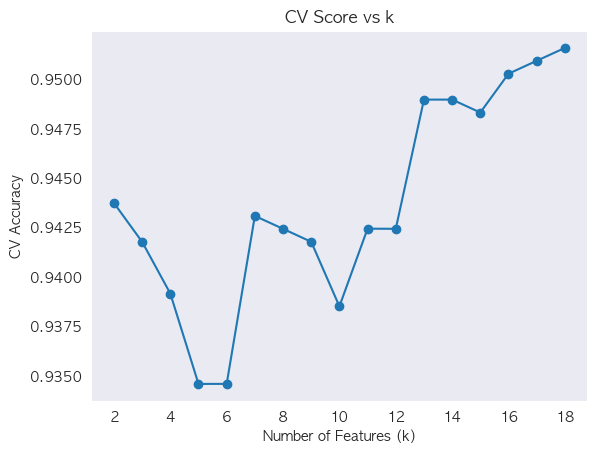

✅ 최적 k = 18
선택된 피처: ['점유율', '패스성공률(%)', '패스 성공', '키패스', '공격진영 패스', '중앙지역 패스', '수비진영 패스', '롱패스', '중거리패스', '단거리패스', '전방패스', '횡패스', '후방패스', '크로스', '패스', '공격진영 패스 비율', '단거리패스 비율', '전방패스 비율']
선택된 피처 개수 18


In [11]:
# 2. GMM 군집 라벨 생성 (hard assignment)
gmm = GaussianMixture(n_components=3, random_state=42)
gmm_labels = gmm.fit_predict(X_scaled)

scores = []
ks = range(2, X_scaled.shape[1] + 1)

for k in ks:
    selector = SelectKBest(score_func=f_classif, k=k)
    X_k = selector.fit_transform(X_scaled, gmm_labels)
    
    score = cross_val_score(LogisticRegression(max_iter=1000),
                            X_k, gmm_labels, cv=5).mean()
    scores.append(score)

# 시각화
plt.plot(ks, scores, marker='o')
plt.title('CV Score vs k')
plt.xlabel('Number of Features (k)')
plt.ylabel('CV Accuracy')
plt.grid()
plt.show()

# 최적 k 선택
optimal_k = ks[np.argmax(scores)]
print(f'✅ 최적 k = {optimal_k}')

selector = SelectKBest(score_func=f_classif, k=optimal_k)
X_selected = selector.fit_transform(X_scaled, gmm_labels)

# PCA
X_pca = PCA(n_components=2).fit_transform(X_selected)

# 선택된 피처 이름
selected_columns = X_raw.columns[selector.get_support()]
print("선택된 피처:", selected_columns.tolist())
print("선택된 피처 개수", len(selected_columns.tolist()))


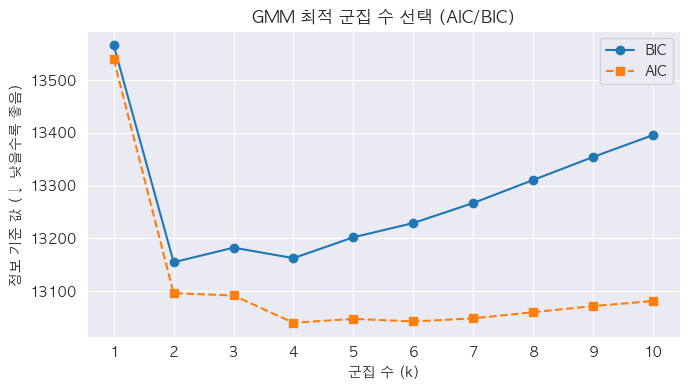

✅ BIC 기준 최적 군집 수: 2


In [12]:
# 군집 수 범위 설정
K_range = range(1, 11)
aic_values = []
bic_values = []

for k in K_range:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X_pca)
    aic_values.append(gmm.aic(X_pca))
    bic_values.append(gmm.bic(X_pca))

plt.rcParams['font.family'] = 'AppleGothic'
plt.figure(figsize=(7, 4))
plt.plot(K_range, bic_values, marker='o', linestyle='-', label='BIC')
plt.plot(K_range, aic_values, marker='s', linestyle='--', label='AIC')
plt.title('GMM 최적 군집 수 선택 (AIC/BIC)')
plt.xlabel('군집 수 (k)')
plt.ylabel('정보 기준 값 (↓ 낮을수록 좋음)')
plt.xticks(K_range)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

optimal_k = K_range[np.argmin(bic_values)]
print(f"✅ BIC 기준 최적 군집 수: {optimal_k}")


/var/folders/2l/dp_ymfg51ylbd7mxz4hb_2wh0000gn/T/ipykernel_28467/2569688611.py:25: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  plt.tight_layout()
/Users/mac_air/PycharmProjects/K-league-pipeline-project/.venv/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from font(s) AppleGothic.
  fig.canvas.print_figure(bytes_io, **kw)


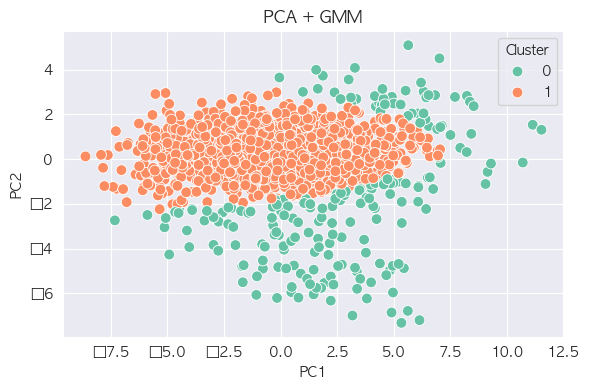

In [13]:
# kmeans = KMeans(n_clusters=k, random_state=42)
# labels_kmeans = kmeans.fit_predict(X_pca)
# 
# # 🔹 Step 3-2. k-medoids 군집화
# kmedoids = KMedoids(n_clusters=k, random_state=42)
# labels_kmedoids = kmedoids.fit_predict(X_pca)
# 
# # 🔹 Step 3-3. 계층적 군집화 (Ward)
# hierarchical = AgglomerativeClustering(n_clusters=k, linkage='ward')
# labels_hier = hierarchical.fit_predict(X_pca)

# 4. GMM 모델 훈련 (군집 수 k 설정)
gmm = GaussianMixture(n_components=optimal_k, random_state=42)
gmm_labels = gmm.fit_predict(X_pca)

# 🔹 Step 4. 결과 시각화
def plot_clusters(X, labels, title):
    plt.rcParams['font.family'] = 'AppleGothic'
    plt.figure(figsize=(6, 4))
    sns.scatterplot(x=X[:, 0], y=X[:, 1], hue=labels, palette='Set2', s=60)
    plt.title(title)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.legend(title='Cluster')
    plt.tight_layout()
    plt.show()

# plot_clusters(X_pca, labels_kmeans, 'PCA + KMeans')
# plot_clusters(X_pca, labels_kmedoids, 'PCA + KMedoids')
# plot_clusters(X_pca, labels_hier, 'PCA + Hierarchical')
plot_clusters(X_pca, gmm_labels, 'PCA + GMM')


In [14]:
# df['cluster_kmeans'] = labels_kmeans
# df['cluster_kmedoids'] = labels_kmedoids
# df['cluster_hierarchical'] = labels_hier
df['cluster_gmm'] = gmm_labels
df['구단'].value_counts()

구단
수원FC    152
강원      148
제주      145
울산      136
인천      135
포항      114
광주      113
서울      111
수원      103
대구       95
전북       85
김천       76
성남       65
대전       51
Name: count, dtype: int64

In [15]:
df['감독'].value_counts()


감독
김기동    152
홍명보    136
조성환    136
김도균    114
남기일    107
김상식     84
이정효     75
이병근     74
안익수     73
김남일     65
최용수     58
최원권     57
윤정환     55
김병수     55
이민성     51
박건하     47
김태완     38
김호영     38
정정용     38
김은중     38
김학범     38
Name: count, dtype: int64

In [16]:
X_selected

array([[-0.53309986, -0.30158378, -0.01500014, ..., -0.14723616,
         0.61033193, -0.88982048],
       [-1.23004783, -2.20376979, -1.30404192, ..., -1.1353879 ,
        -2.76438367, -0.42215319],
       [ 0.38648426, -0.46009928,  0.22010811, ..., -0.31522746,
        -0.29518682,  0.49325264],
       ...,
       [-0.62021836, -0.30158378, -0.68789616, ..., -1.2010085 ,
        -0.0534807 ,  0.49260896],
       [ 0.29936577,  1.44208674,  0.56060971, ...,  4.14128584,
         1.562813  ,  1.18333177],
       [ 0.35744476,  0.33247823,  0.04175013, ...,  0.41613521,
         1.57922917,  0.75312025]])

In [17]:
from scipy.stats import chi2_contingency

algorithm = 'cluster_gmm'
# 교차표
crosstab_team = pd.crosstab(df['구단'], df[f'{algorithm}'])

print(crosstab_team)

cluster_gmm   0    1
구단                  
강원           13  135
광주            9  104
김천           18   58
대구            4   91
대전            1   50
서울           30   81
성남            5   60
수원           10   93
수원FC         18  134
울산           41   95
인천           11  124
전북            8   77
제주           14  131
포항           30   84


In [18]:
crosstab_manager = pd.crosstab(df['감독'], df[f'{algorithm}'])
print(crosstab_manager)

cluster_gmm   0    1
감독                  
김기동          34  118
김남일           5   60
김도균          13  101
김병수           3   52
김상식           8   76
김은중           5   33
김태완          14   24
김학범           0   38
김호영           2   36
남기일          14   93
박건하           1   46
안익수          26   47
윤정환           2   53
이민성           1   50
이병근          10   64
이정효           7   68
정정용           4   34
조성환          11  125
최용수           8   50
최원권           3   54
홍명보          41   95


In [19]:
# 카이제곱 검정
chi2_team, p_team, dof_team, expected_team = chi2_contingency(crosstab_team)

print(f"📊 [구단 vs {algorithm} 군집] 카이제곱 통계량:", chi2_team)
print("p-value:", p_team)
print("자유도:", dof_team)


📊 [구단 vs cluster_gmm 군집] 카이제곱 통계량: 98.52524140892919
p-value: 3.2016252836951168e-15
자유도: 13


In [20]:
# 카이제곱 검정
chi2_mgr, p_mgr, dof_mgr, expected_mgr = chi2_contingency(crosstab_manager)

print(f"📊 [감독 vs {algorithm} 군집] 카이제곱 통계량:", chi2_mgr)
print("p-value:", p_mgr)
print("자유도:", dof_mgr)


📊 [감독 vs cluster_gmm 군집] 카이제곱 통계량: 126.16201563989252
p-value: 2.037812508867938e-17
자유도: 20


In [21]:
import numpy as np

def cramers_v(chi2, n, k_row, k_col):
    return np.sqrt(chi2 / (n * (min(k_row - 1, k_col - 1))))

# 샘플 수 (경기 수)
n = len(df)

# 팀 vs 군집
v_team = cramers_v(chi2_team, n, crosstab_team.shape[0], crosstab_team.shape[1])

# 감독 vs 군집
v_mgr = cramers_v(chi2_mgr, n, crosstab_manager.shape[0], crosstab_manager.shape[1])

print(f"📏 Cramér's V (팀 vs 군집): {v_team:.4f}")
print(f"📏 Cramér's V (감독 vs 군집): {v_mgr:.4f}")


📏 Cramér's V (팀 vs 군집): 0.2538
📏 Cramér's V (감독 vs 군집): 0.2873


In [22]:
def compare_cramers_v(v1, v2, n):
    se = np.sqrt((1 - v1**2)/n + (1 - v2**2)/n)
    z = (v2 - v1) / se
    from scipy.stats import norm
    p = 2 * (1 - norm.cdf(abs(z)))
    return z, p

z_value, p_value = compare_cramers_v(v_team, v_mgr, n=len(df))

print(f"📈 Z = {z_value:.3f}")
print(f"📉 p-value = {p_value:.5f}")

📈 Z = 0.960
📉 p-value = 0.33728


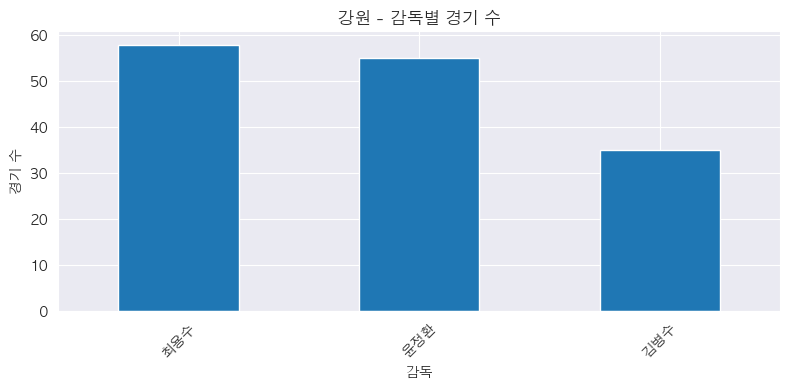

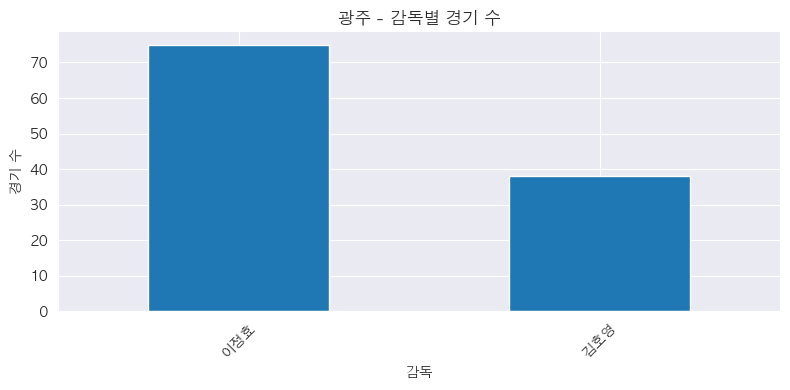

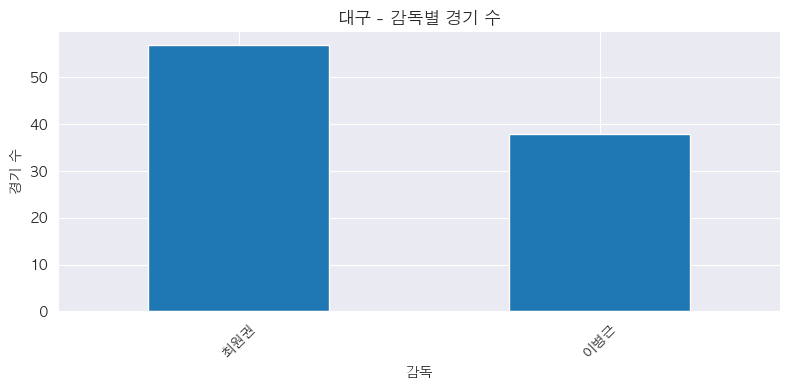

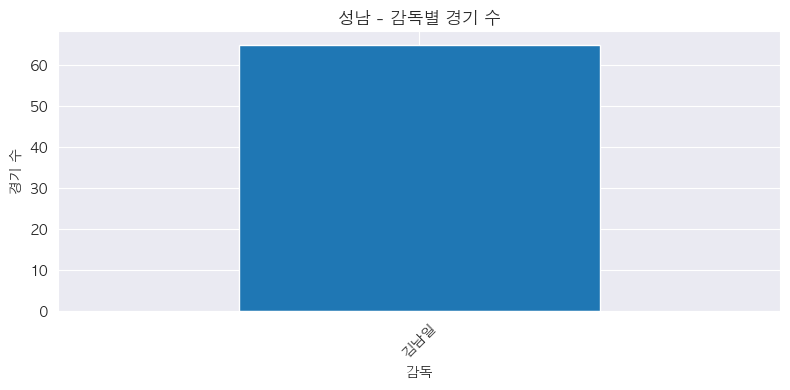

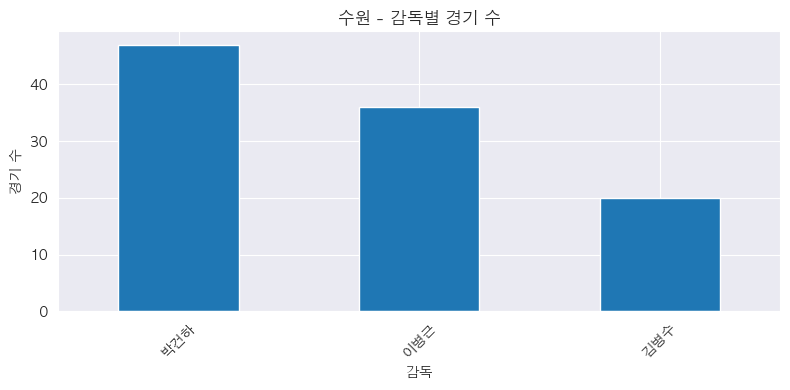

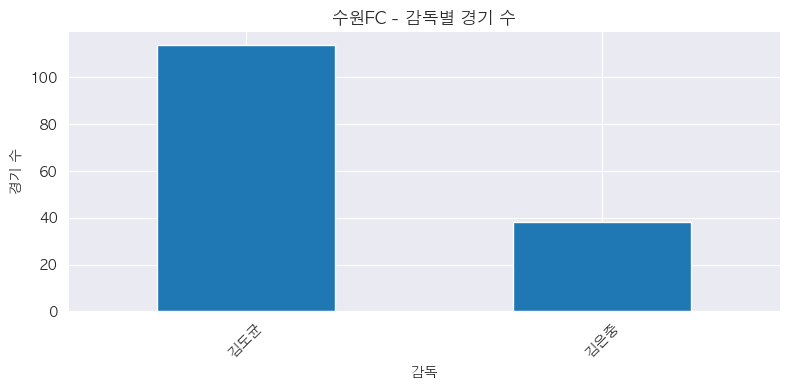

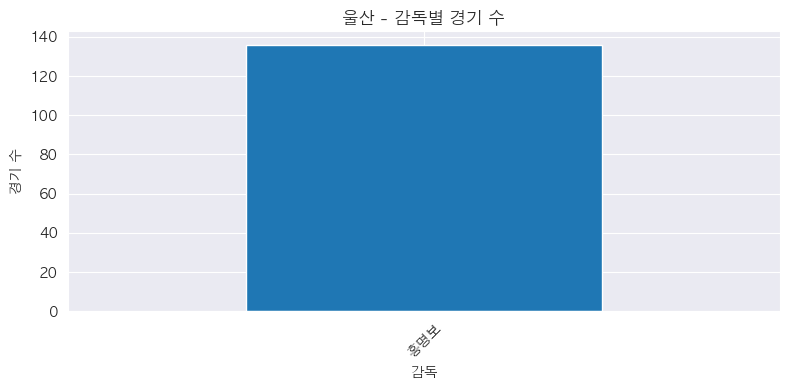

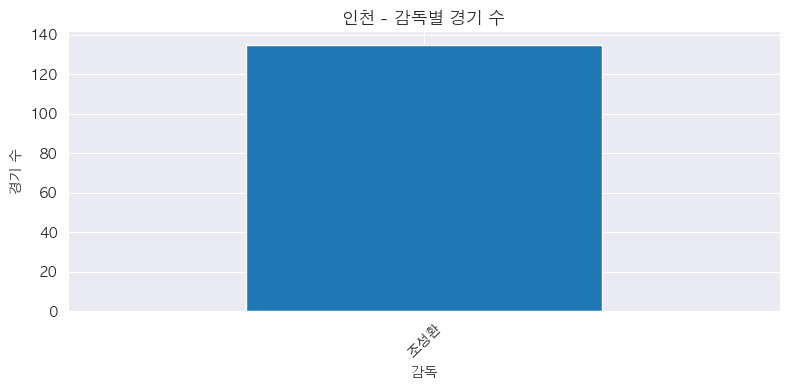

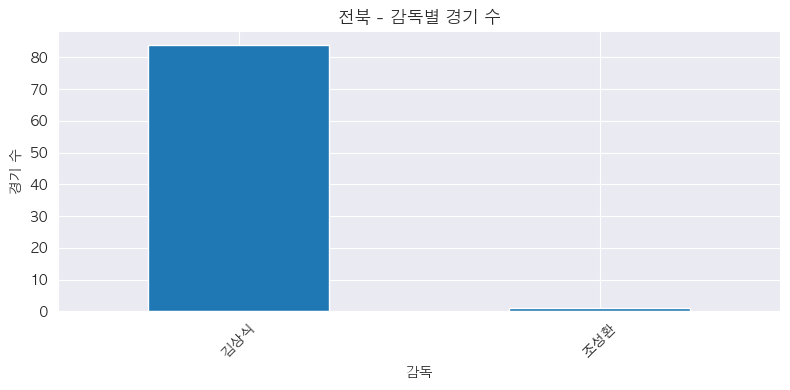

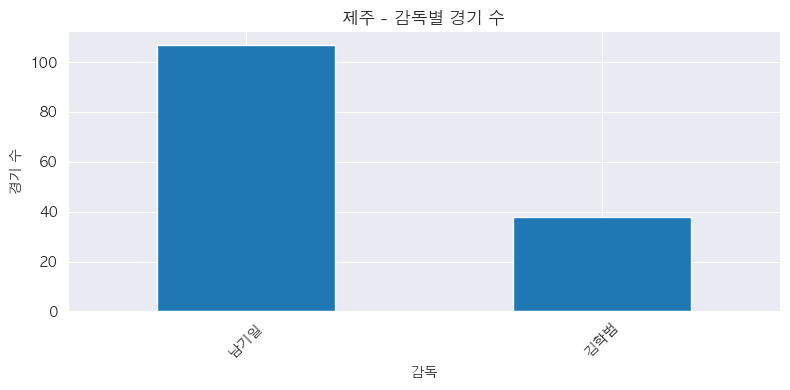

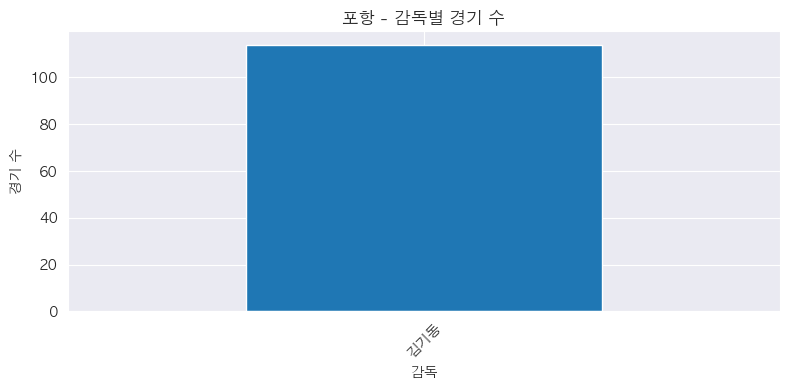

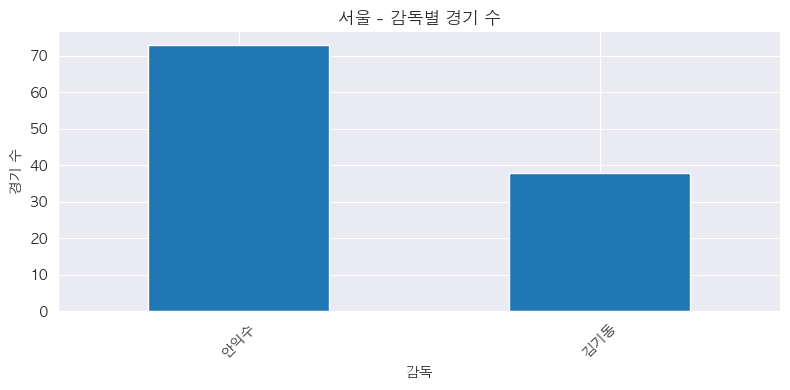

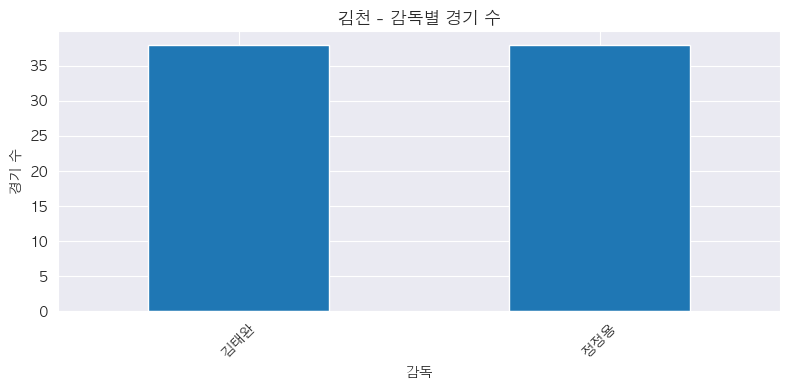

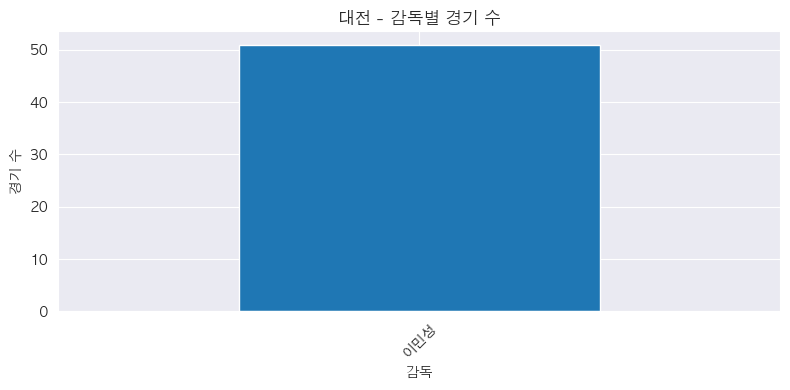

In [23]:
teams = df['구단'].unique()
target_team = []
# 시각화 반복
for idx, team in enumerate(teams):
    plt.figure(figsize=(8, 4))
    target = df[df['구단'] == team]['감독'].value_counts()
    manager_list = target.reset_index()['감독'].tolist()
    if len(manager_list) >= 2:
        target_team.append({team: manager_list})
    target.plot(kind='bar')
    plt.title(f'{team} - 감독별 경기 수')
    plt.xlabel('감독')
    plt.ylabel('경기 수')
    plt.xticks(rotation=45)
    plt.tight_layout()
    # plt.show()

In [24]:
print(target_team)


[{'강원': ['최용수', '윤정환', '김병수']}, {'광주': ['이정효', '김호영']}, {'대구': ['최원권', '이병근']}, {'수원': ['박건하', '이병근', '김병수']}, {'수원FC': ['김도균', '김은중']}, {'전북': ['김상식', '조성환']}, {'제주': ['남기일', '김학범']}, {'서울': ['안익수', '김기동']}, {'김천': ['김태완', '정정용']}]


In [25]:
# Cramér's V 계산 함수
def cramers_v(chi2, n, r, c):
    if min(r, c) <= 1:
        return None
    return np.sqrt(chi2 / (n * (min(r - 1, c - 1))))

# 팀-감독 리스트
team_manager_list = [
    {'강원': ['최용수', '윤정환', '김병수']},
    {'광주': ['이정효', '김호영']},
    {'대구': ['최원권', '이병근']},
    {'수원': ['박건하', '이병근', '김병수']},
    {'수원FC': ['김도균', '김은중']},
    {'제주': ['남기일', '김학범']},
    {'서울': ['안익수', '김기동']},
    {'김천': ['김태완', '정정용']}
]

results = []

# 분석 반복
for item in team_manager_list:
    for team, managers in item.items():
        # 데이터 필터링: 해당 팀 + 해당 감독들만
        df_sub = df[(df['구단'] == team) & (df['감독'].isin(managers))]

        if df_sub['감독'].nunique() >= 2 and df_sub['cluster_gmm'].nunique() > 1:
            # 교차표: 감독 vs 군집
            ct = pd.crosstab(df_sub['감독'], df_sub['cluster_gmm'])
            print(ct)

            if ct.shape[0] > 1 and ct.shape[1] > 1:
                chi2, p, dof, expected = chi2_contingency(ct)
                n = df_sub.shape[0]
                v = cramers_v(chi2, n, ct.shape[0], ct.shape[1])

                results.append({
                    '팀': team,
                    '감독 수': ct.shape[0],
                    '경기 수': n,
                    'chi2': round(chi2, 3),
                    'p-value': round(p, 5),
                    "Cramér's V": round(v, 4) if v else None
                })
            else:
                results.append({
                    '팀': team,
                    '감독 수': ct.shape[0],
                    '경기 수': df_sub.shape[0],
                    'chi2': None,
                    'p-value': None,
                    "Cramér's V": None
                })

# 결과 DataFrame 생성
df_results = pd.DataFrame(results)
print(df_results.sort_values('Cramér\'s V', ascending=False))

cluster_gmm  0   1
감독                
김병수          3  32
윤정환          2  53
최용수          8  50
cluster_gmm  0   1
감독                
김호영          2  36
이정효          7  68
cluster_gmm  0   1
감독                
이병근          1  37
최원권          3  54
cluster_gmm  0   1
감독                
김병수          0  20
박건하          1  46
이병근          9  27
cluster_gmm   0    1
감독                  
김도균          13  101
김은중           5   33
cluster_gmm   0   1
감독                 
김학범           0  38
남기일          14  93
cluster_gmm   0   1
감독                 
김기동           4  34
안익수          26  47
cluster_gmm   0   1
감독                 
김태완          14  24
정정용           4  34
      팀  감독 수  경기 수    chi2  p-value  Cramér's V
3    수원     3   103  14.834  0.00060      0.3795
7    김천     2    76   5.897  0.01517      0.2785
6    서울     2   111   6.755  0.00935      0.2467
5    제주     2   145   4.106  0.04274      0.1683
0    강원     3   148   3.637  0.16225      0.1568
1    광주     2   113   0.150  0.69857    

In [26]:
df_results

,팀,감독 수,경기 수,chi2,p-value,Cramér's V
0,강원,3,148,3.637,0.16225,0.1568
1,광주,2,113,0.150,0.69857,0.0364
2,대구,2,95,0.011,0.91695,0.0107
3,수원,3,103,14.834,0.00060,0.3795
4,수원FC,2,152,0.000,1.00000,NaN
5,제주,2,145,4.106,0.04274,0.1683
6,서울,2,111,6.755,0.00935,0.2467
7,김천,2,76,5.897,0.01517,0.2785
